In [1]:
import pandas as pd,numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
for column in df.columns.tolist():

    plt.figure(figsize = (8,6))

    if df[column].nunique() > 10:

        sns.histplot(x = df[column])

    else:

        sns.countplot(x = df[column])
    
    plt.title(column)
    plt.show()

How many values do we have with cholesterol == 0?

In [6]:
print(f"Values where cholesterol is zero: {len(df[df.Cholesterol == 0])}")

Values where cholesterol is zero: 172


In [7]:
df.loc[df.Cholesterol == 0,'Cholesterol'] = np.nan

In [17]:
from sklearn.base import BaseEstimator,TransformerMixin

class MultiColumnEncoder(BaseEstimator,TransformerMixin):
    
    def __init__(self,
                 column_list:list = None,
                 encoder_dict: dict = None,
                 base_encoder = OrdinalEncoder()) -> pd.DataFrame:

        #Set the user-definied column list to the class attribute _columns_to_encode
        self._columns_to_encode = column_list

        if base_encoder is None:
            self._base_encoder = OrdinalEncoder()
        else:
            self._base_encoder = base_encoder

        #If the user passes their own encoder dict
        if not encoder_dict:
            self._encoder_dict = {column:self._base_encoder for column in self._columns_to_encode}
        else:
            self._encoder_dict = encoder_dict
    
    def fit(self,X,y = None):
        pass

    def fit_transform(self,X,y = None):

        if not isinstance(X,pd.DataFrame):
            raise Exception(f"Input datatype must be Pandas Dataframe.  Object passed was of type {type(X)}")
        
        for column in self._columns_to_encode:
            if column not in X.columns.tolist():
                raise Exception(f"{column} is mising from the input Dataframe")
        
        df = X.copy()

        for column in df.columns.tolist():

            if column not in self._columns_to_encode:
                continue

            df[column] = self._encoder_dict[column].fit_transform(df[column].to_numpy().reshape(-1,1))
        
        return df


        
        
test = MultiColumnEncoder(['Sex','ExerciseAngina'],base_encoder=OrdinalEncoder(dtype = 'int64'))
test.fit_transform(df)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289.0,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180.0,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283.0,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214.0,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195.0,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264.0,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144,193.0,1,Normal,141,0,3.4,Flat,1
915,57,1,ASY,130,131.0,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130,236.0,0,LVH,174,0,0.0,Flat,1


In [53]:
columns_to_encode = df.select_dtypes(include = object).columns.tolist()

column_transformer = make_column_transformer(

        (OrdinalEncoder(dtype = int),['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']),
        (SimpleImputer(),['Cholesterol']),
        remainder='passthrough'
                                            )

test = pd.DataFrame(column_transformer.fit_transform(df).astype(int),columns = df.columns.tolist())

In [54]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(dtype=<class 'int'>),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina', 'ST_Slope']),
                                ('simpleimputer', SimpleImputer(),
                                 ['Cholesterol'])])

<AxesSubplot:xlabel='Cholesterol', ylabel='Count'>

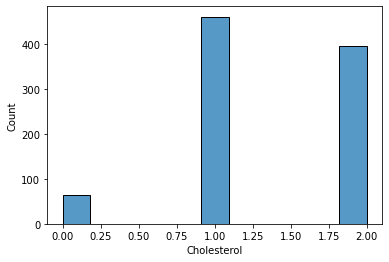

In [48]:
sns.histplot(test.Cholesterol)